In [1]:
%matplotlib inline
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [3]:
def model(t_u, w, b):
    return w * t_u + b

In [4]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [5]:
w = torch.ones(())
b = torch.zeros(())

t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [6]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8846)

In [7]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


In [8]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [9]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [10]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

In [11]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

In [12]:
def dmodel_dw(t_u, w, b):
    return t_u

In [13]:
def dmodel_db(t_u, w, b):
    return 1.0

In [14]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1>

In [15]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        print('------')
        print('Epoch %d, Loss %f, ' % (epoch, float(loss))) # <3>
        print('Params: ', params)
        print('Grad: ', grad)
        print('------')
            
    return params

In [16]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [17]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884644
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2969,   82.6000])
Epoch 2, Loss 5802485.500000
    Params: tensor([2568.4014,   45.1637])
    Grad:   tensor([-261257.4219,   -4598.9712])
Epoch 3, Loss 19408035840.000000
    Params: tensor([-148527.7344,   -2616.3933])
    Grad:   tensor([15109614.0000,   266155.7188])
...
Epoch 10, Loss 90901154706620645225508955521810432.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

In [18]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884644
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2969,   82.6000])
Epoch 2, Loss 323.090546
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4667,  16.5122])
...
Epoch 10, Loss 29.105242
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022669
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

In [19]:
t_un = 0.1 * t_u
t_un

tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800,
        4.8400, 6.0400, 6.8400])

In [20]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574917
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030487
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941875
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

In [21]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
#     print_params = False
)

params

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574917
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030487
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941875
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])
...
Epoch 4000, Loss 2.927680
    Params: tensor([  5.3643, -17.2853])
    Grad:   tensor([-0.0006,  0.0033])
Epoch 5000, Loss 2.927648
    Params: tensor([  5.3671, -17.3012])
    Grad:   tensor([-0.0001,  0.0006])


tensor([  5.3671, -17.3012])

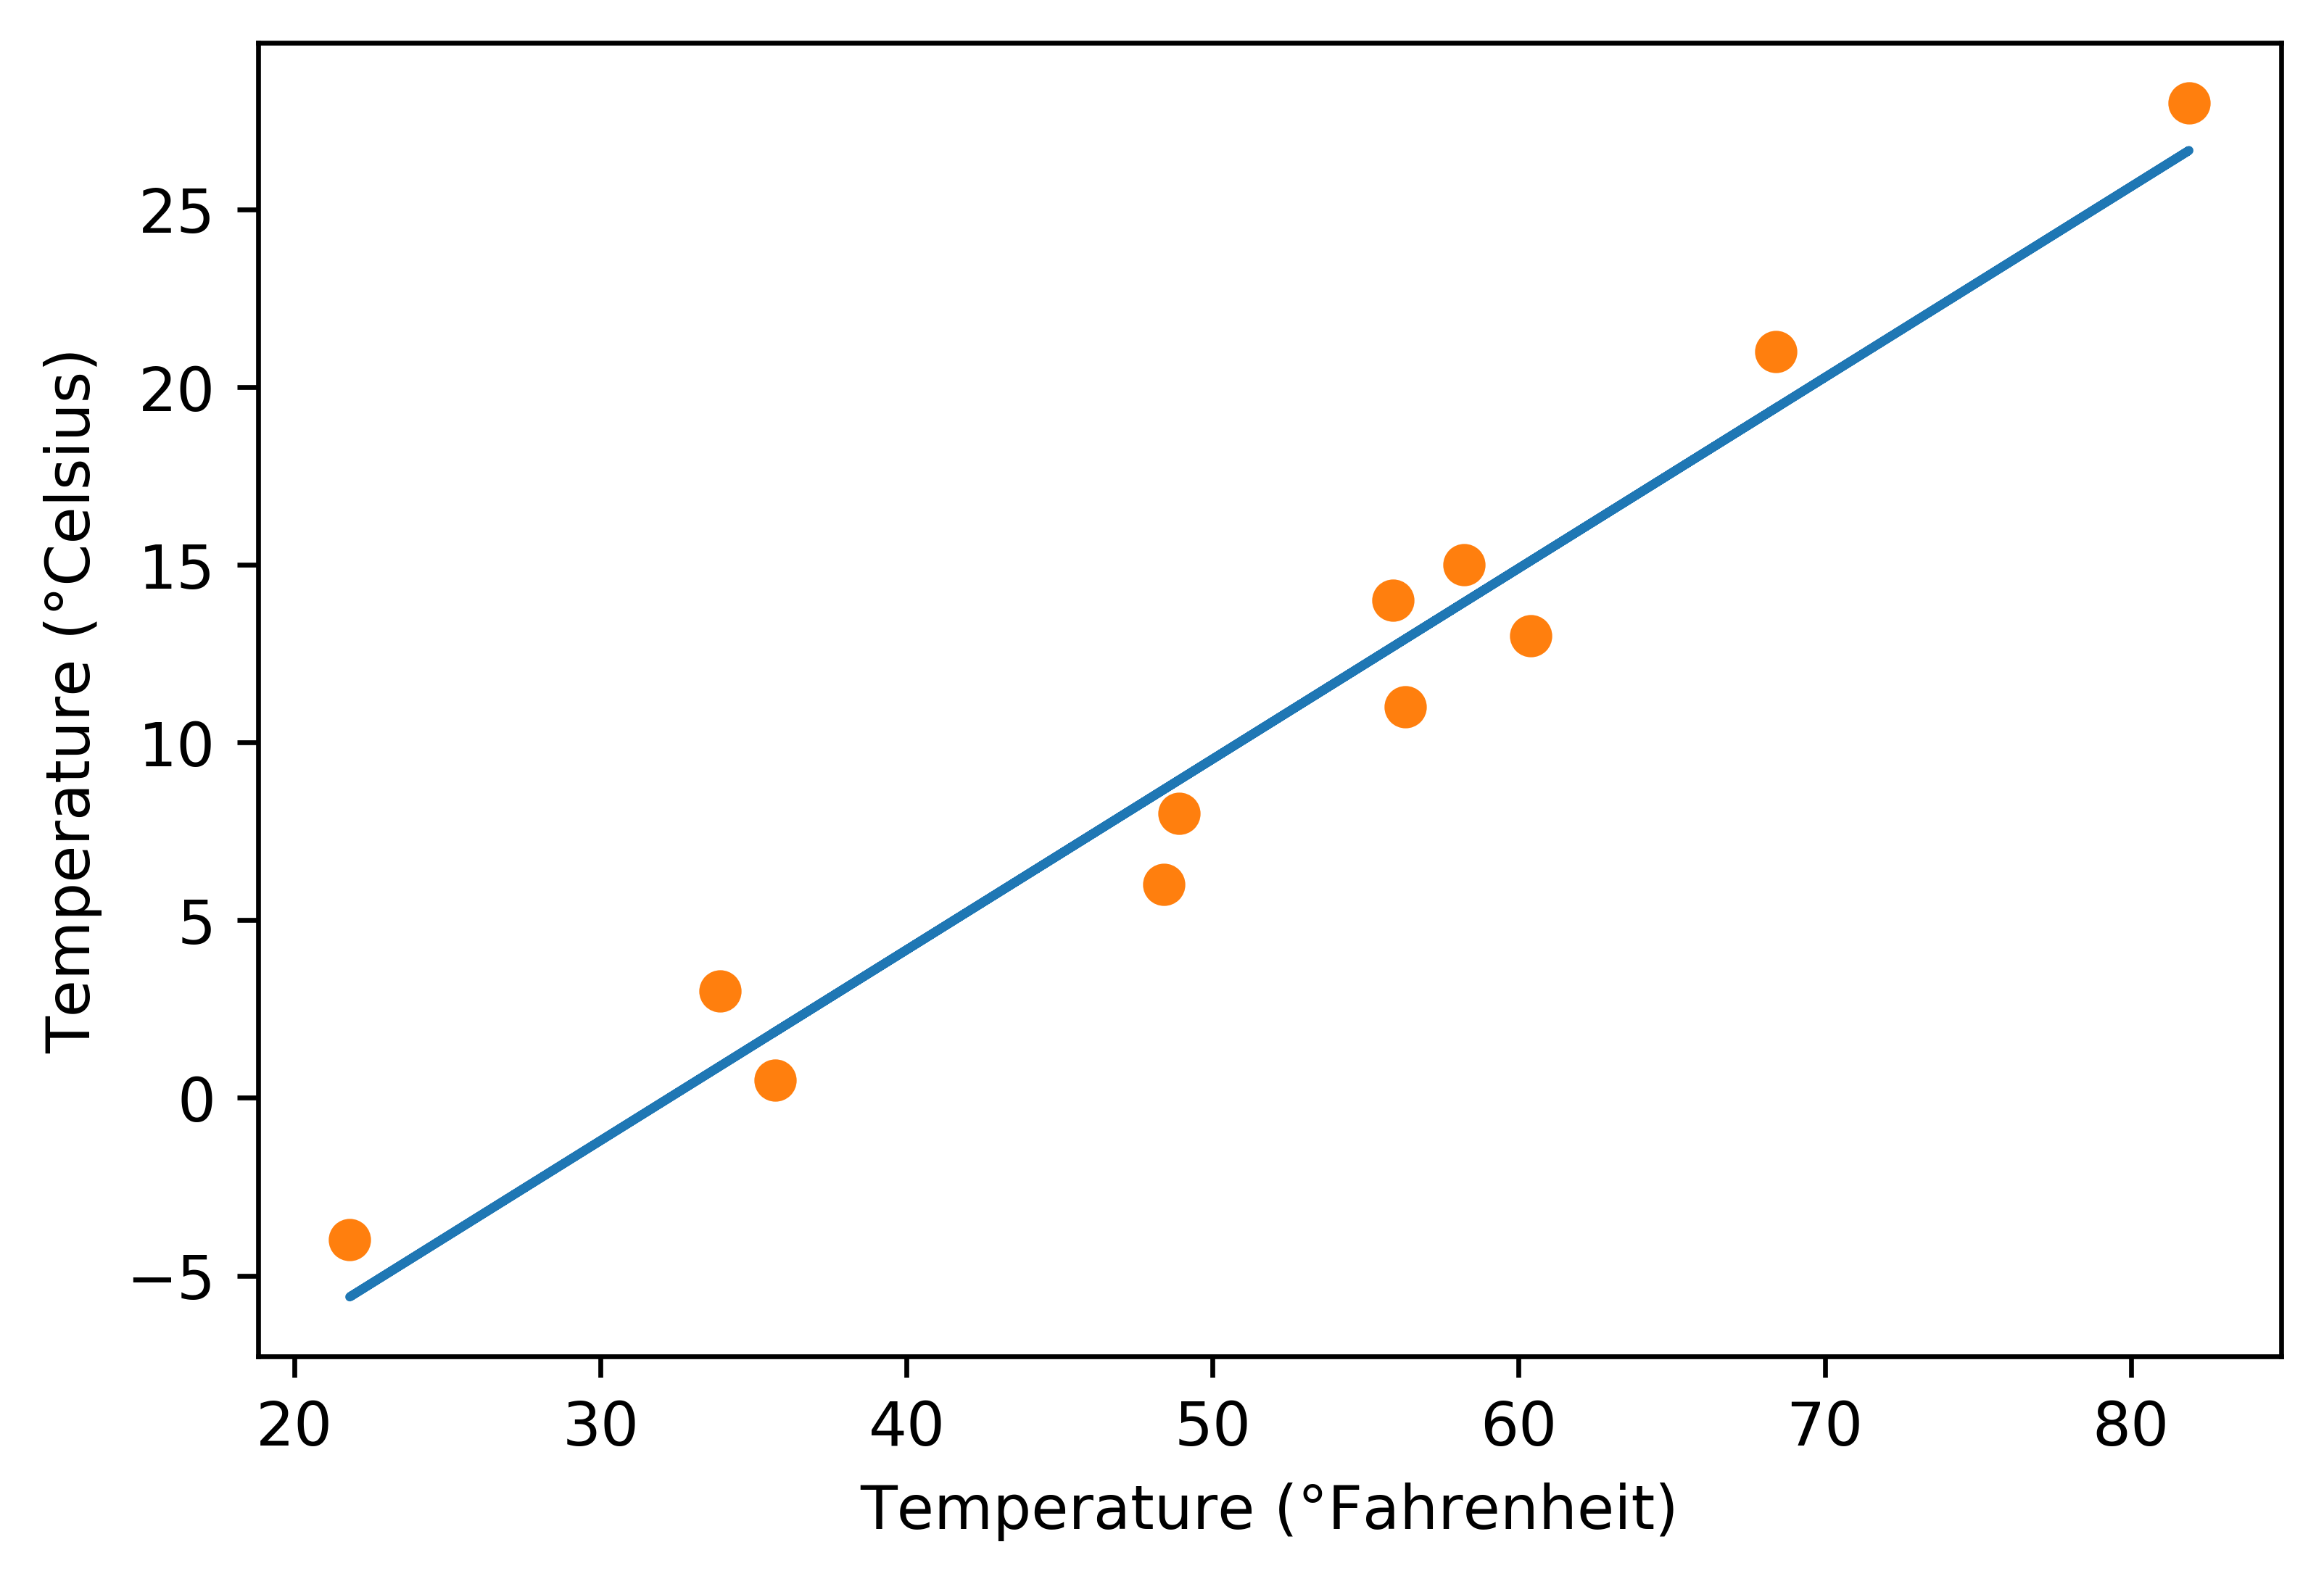

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)  # <1>

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")  # bookskip

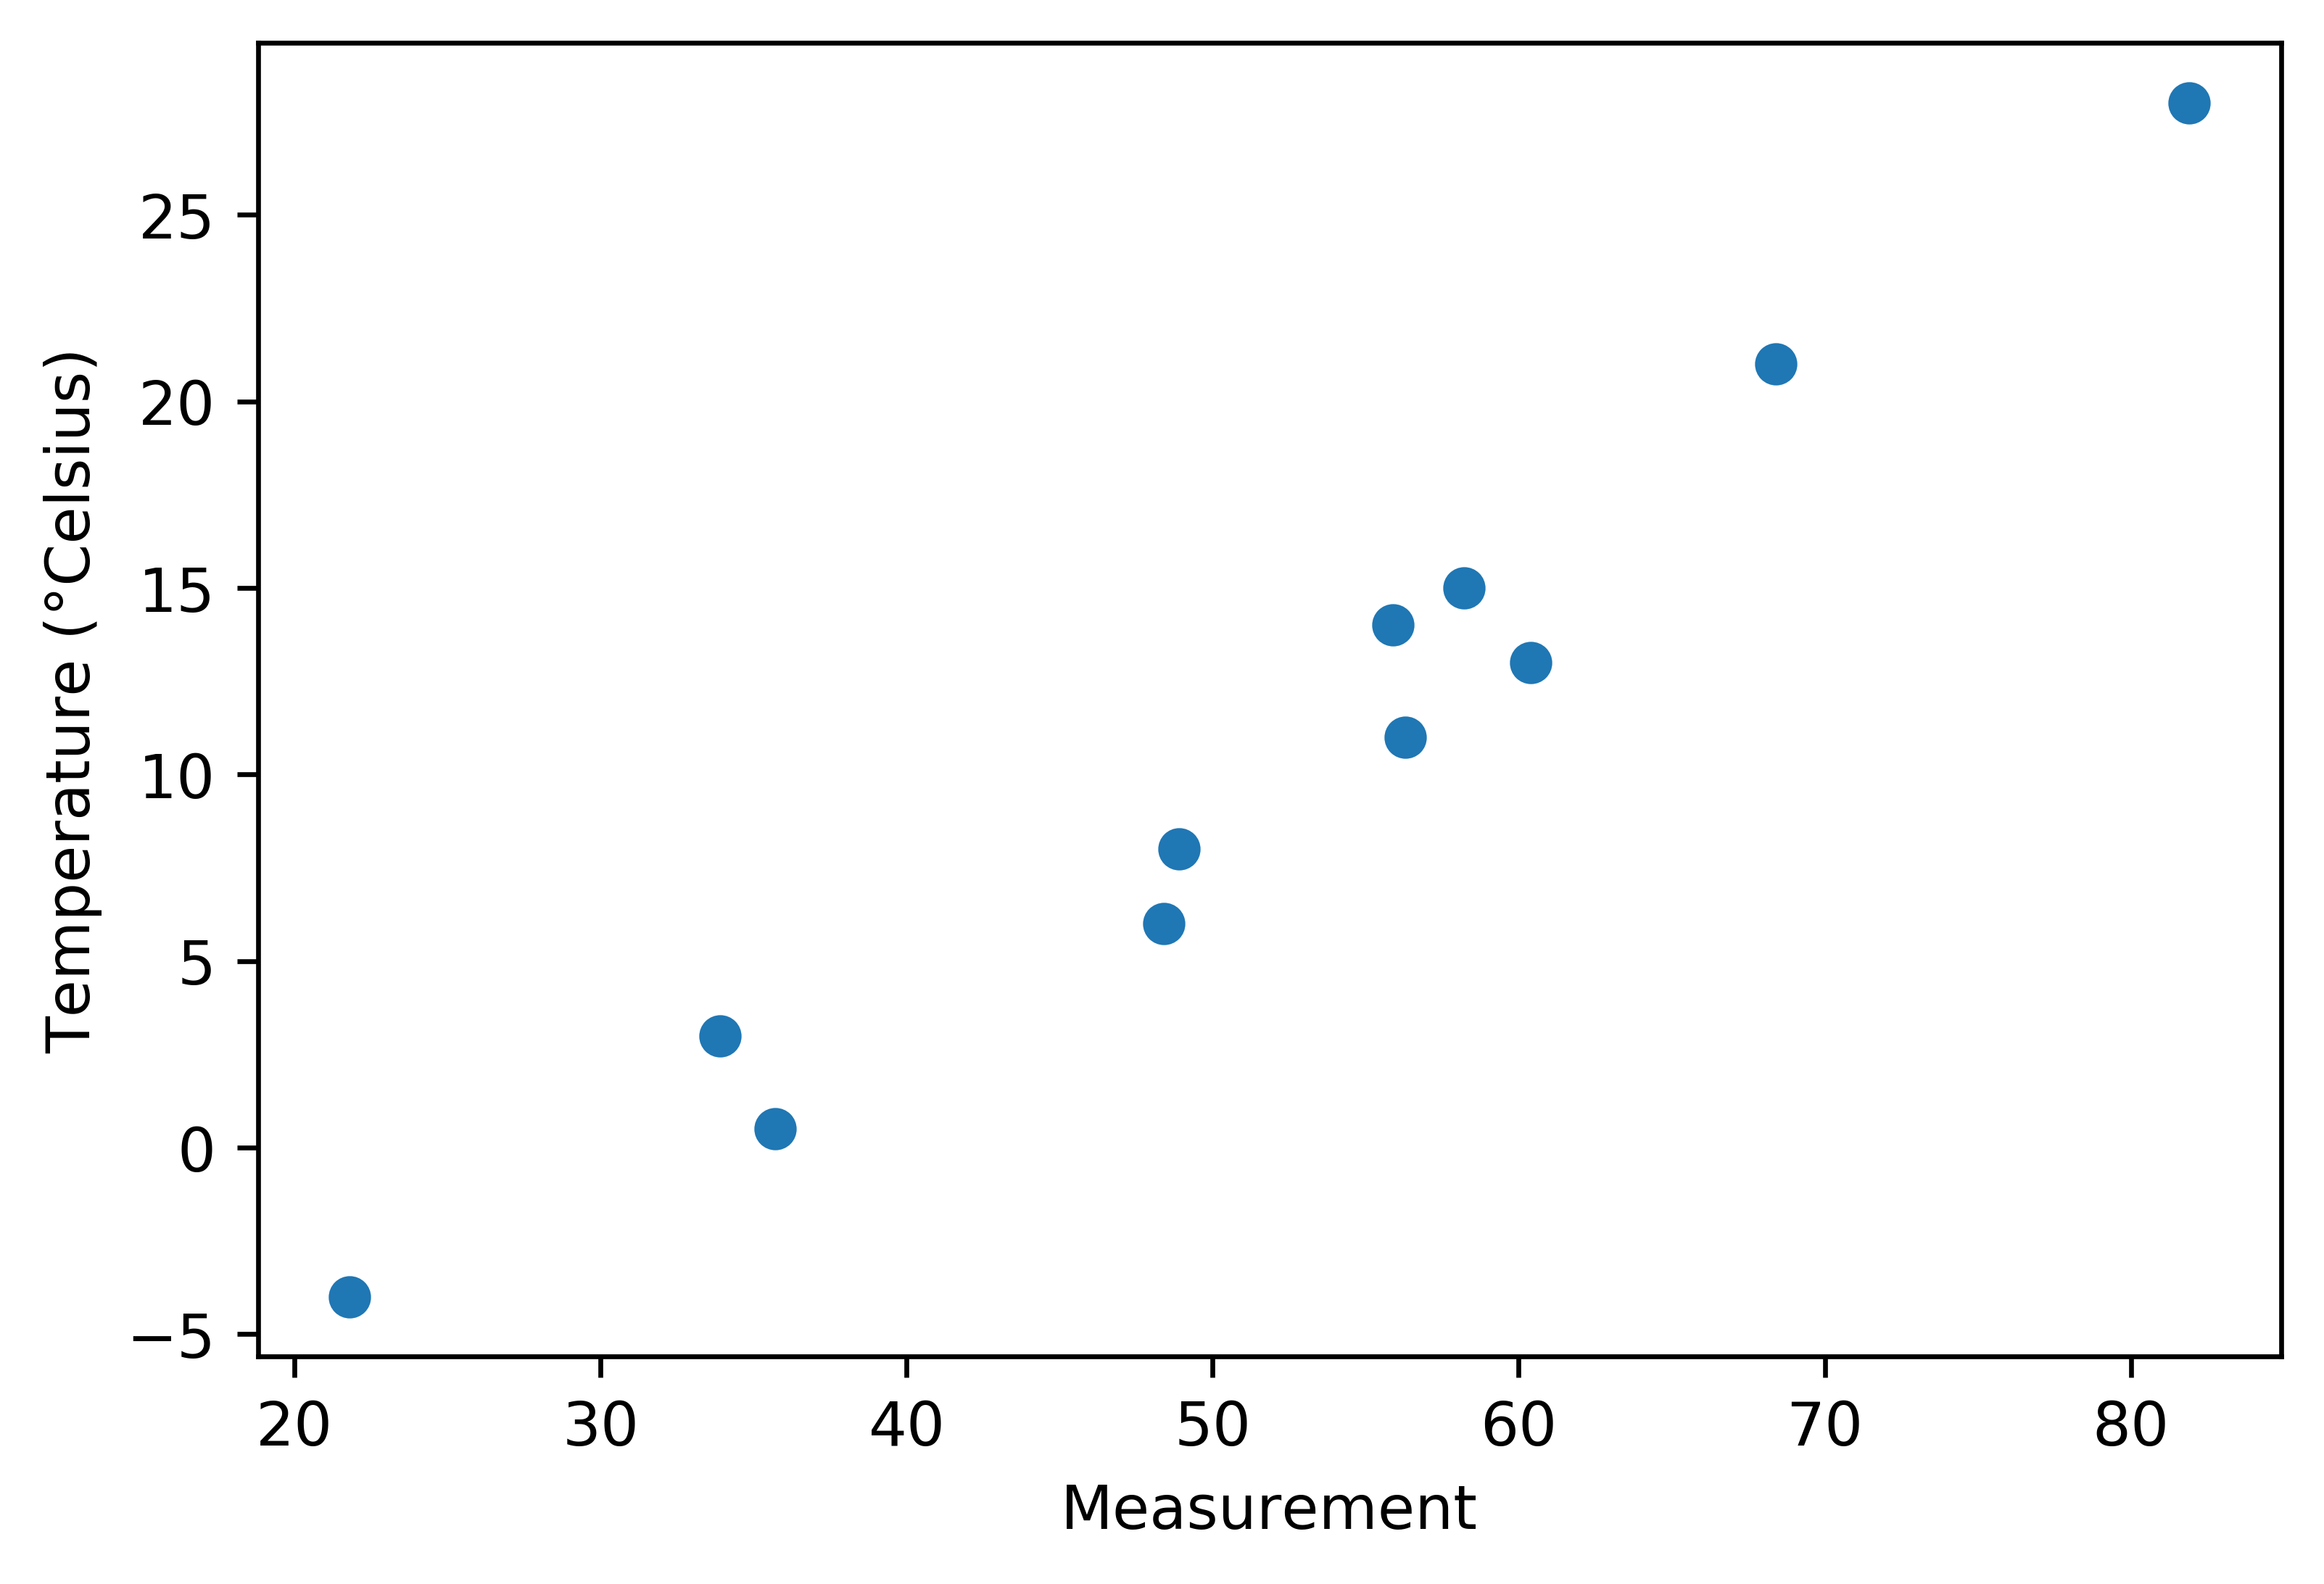

In [23]:
%matplotlib inline
from matplotlib import pyplot as plt

fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

plt.savefig("temp_data_plot.png", format="png")

In [24]:
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [25]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()
            
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():
            params -= learning_rate * params.grad
            
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [26]:
training_loop(
    n_epochs = 5000,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0], requires_grad=True),
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860116
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957697
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [27]:
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 == 0:
            print('Epoch %d, Loss %f ' % (epoch, float(loss)))
            
    return params

In [28]:
import torch.optim as optim
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

In [29]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    t_u = t_un,
    t_c = t_c)

Epoch 500, Loss 7.860118 
Epoch 1000, Loss 3.828538 
Epoch 1500, Loss 3.092191 
Epoch 2000, Loss 2.957697 
Epoch 2500, Loss 2.933134 
Epoch 3000, Loss 2.928648 
Epoch 3500, Loss 2.927830 
Epoch 4000, Loss 2.927680 
Epoch 4500, Loss 2.927651 
Epoch 5000, Loss 2.927648 


tensor([  5.3671, -17.3012], requires_grad=True)

In [30]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

In [31]:
training_loop(
    n_epochs = 2000,
    optimizer = optimizer,
    params = params,
    t_u = t_u,
    t_c = t_c)

Epoch 500, Loss 7.612903 
Epoch 1000, Loss 3.086700 
Epoch 1500, Loss 2.928578 
Epoch 2000, Loss 2.927646 


tensor([  0.5367, -17.3021], requires_grad=True)

In [32]:
n_samples = t_u.shape[0]
t_u.shape

torch.Size([11])

In [33]:
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
n_val

2

In [34]:
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]
train_indices, val_indices

(tensor([ 3,  5,  9, 10,  2,  0,  6,  7,  1]), tensor([8, 4]))

In [35]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

In [36]:
val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

In [37]:
train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [38]:
def training_loop(n_epochs, optimizer, params, train_t_u,
                  val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 == 0:
#             print(f'Val_t_p: {val_t_p}, Val_t_c: {val_t_c}')
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")
    return params

In [39]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

In [40]:
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    params = params,
    train_t_u = train_t_un,
    val_t_u = val_t_un,
    train_t_c = train_t_c,
    val_t_c = val_t_c)

Epoch 1, Training loss 94.8695, Validation loss 15.0912
Epoch 2, Training loss 41.5927, Validation loss 5.0624
Epoch 3, Training loss 33.5647, Validation loss 12.8680
Epoch 500, Training loss 6.1184, Validation loss 11.9401
Epoch 1000, Training loss 2.6418, Validation loss 9.3247
Epoch 1500, Training loss 2.1846, Validation loss 8.4743
Epoch 2000, Training loss 2.1245, Validation loss 8.1789
Epoch 2500, Training loss 2.1166, Validation loss 8.0734
Epoch 3000, Training loss 2.1155, Validation loss 8.0354
Epoch 3500, Training loss 2.1154, Validation loss 8.0216
Epoch 4000, Training loss 2.1154, Validation loss 8.0166
Epoch 4500, Training loss 2.1154, Validation loss 8.0149
Epoch 5000, Training loss 2.1154, Validation loss 8.0142


tensor([  5.3679, -16.7956], requires_grad=True)

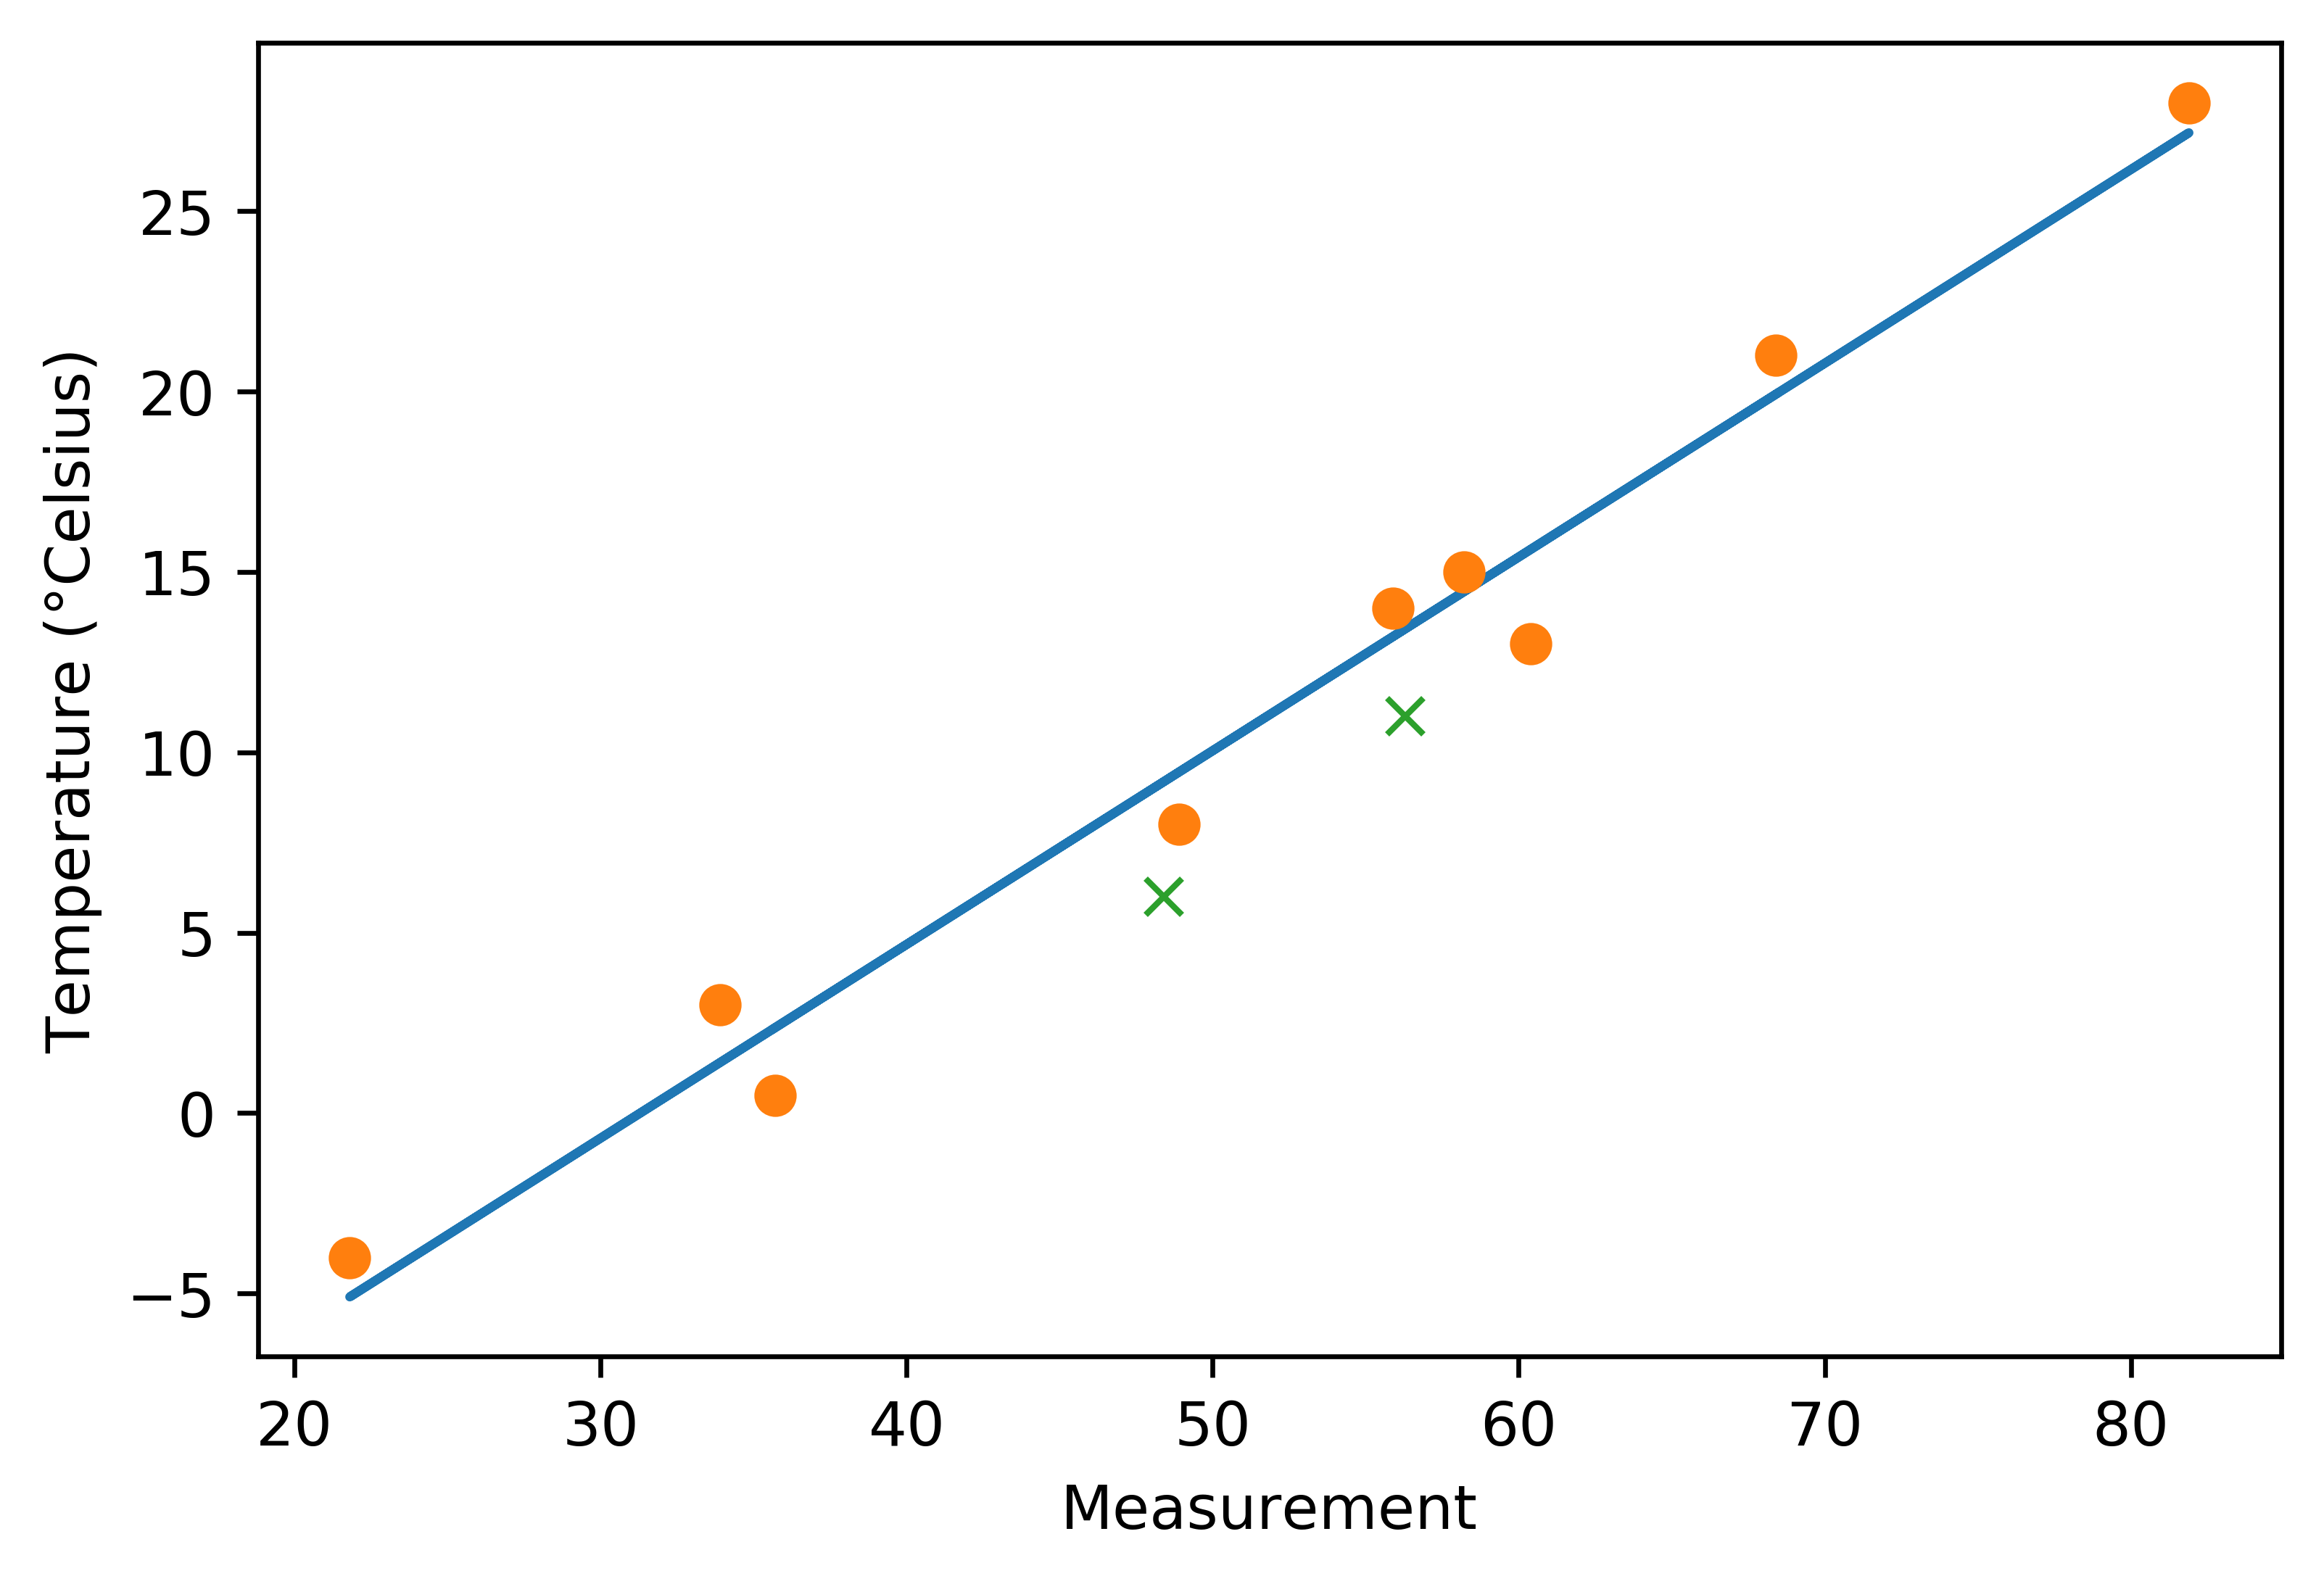

In [41]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(train_t_u.numpy(), train_t_c.numpy(), 'o')
plt.plot(val_t_u.numpy(), val_t_c.numpy(), 'x')

plt.savefig("separe_training_and_validation_sets.png", format="png")

In [42]:
import torch.nn as nn

In [43]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                 t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        # calculate training loss
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)
        
        # calculate validation loss
        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Train loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [44]:
print(val_t_u)
print(train_t_u)
print(val_t_c)
print(train_t_c)

tensor([48.4000, 56.3000])
tensor([81.9000, 48.9000, 60.4000, 68.4000, 58.2000, 35.7000, 33.9000,
        21.8000, 55.9000])
tensor([ 6., 11.])
tensor([28.0000,  8.0000, 13.0000, 21.0000, 15.0000,  0.5000,  3.0000,
        -4.0000, 14.0000])


In [45]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)
training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train = train_t_u.unsqueeze(1) * 0.1,
    t_u_val = val_t_u.unsqueeze(1) * 0.1,
    t_c_train = train_t_c.unsqueeze(1),
    t_c_val = val_t_c.unsqueeze(1))
print("Parameters: ", list(linear_model.parameters()))

Epoch 1, Train loss 139.3987, Validation loss 34.4406
Epoch 1000, Train loss 2.6961, Validation loss 9.3940
Epoch 2000, Train loss 2.1254, Validation loss 8.1872
Epoch 3000, Train loss 2.1155, Validation loss 8.0365
Parameters:  [Parameter containing:
tensor([[5.3609]], requires_grad=True), Parameter containing:
tensor([-16.7556], requires_grad=True)]


tensor([3.5700, 5.5900, 5.8200, 8.1900, 5.6300, 4.8900, 3.3900, 2.1800,
        4.8400, 6.0400, 6.8400])
tensor([ 2.3830, 13.2121, 14.4451, 27.1505, 13.4265,  9.4594,  1.4180,
        -5.0687,  9.1914, 15.6245, 19.9133], grad_fn=<SqueezeBackward0>)
tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])


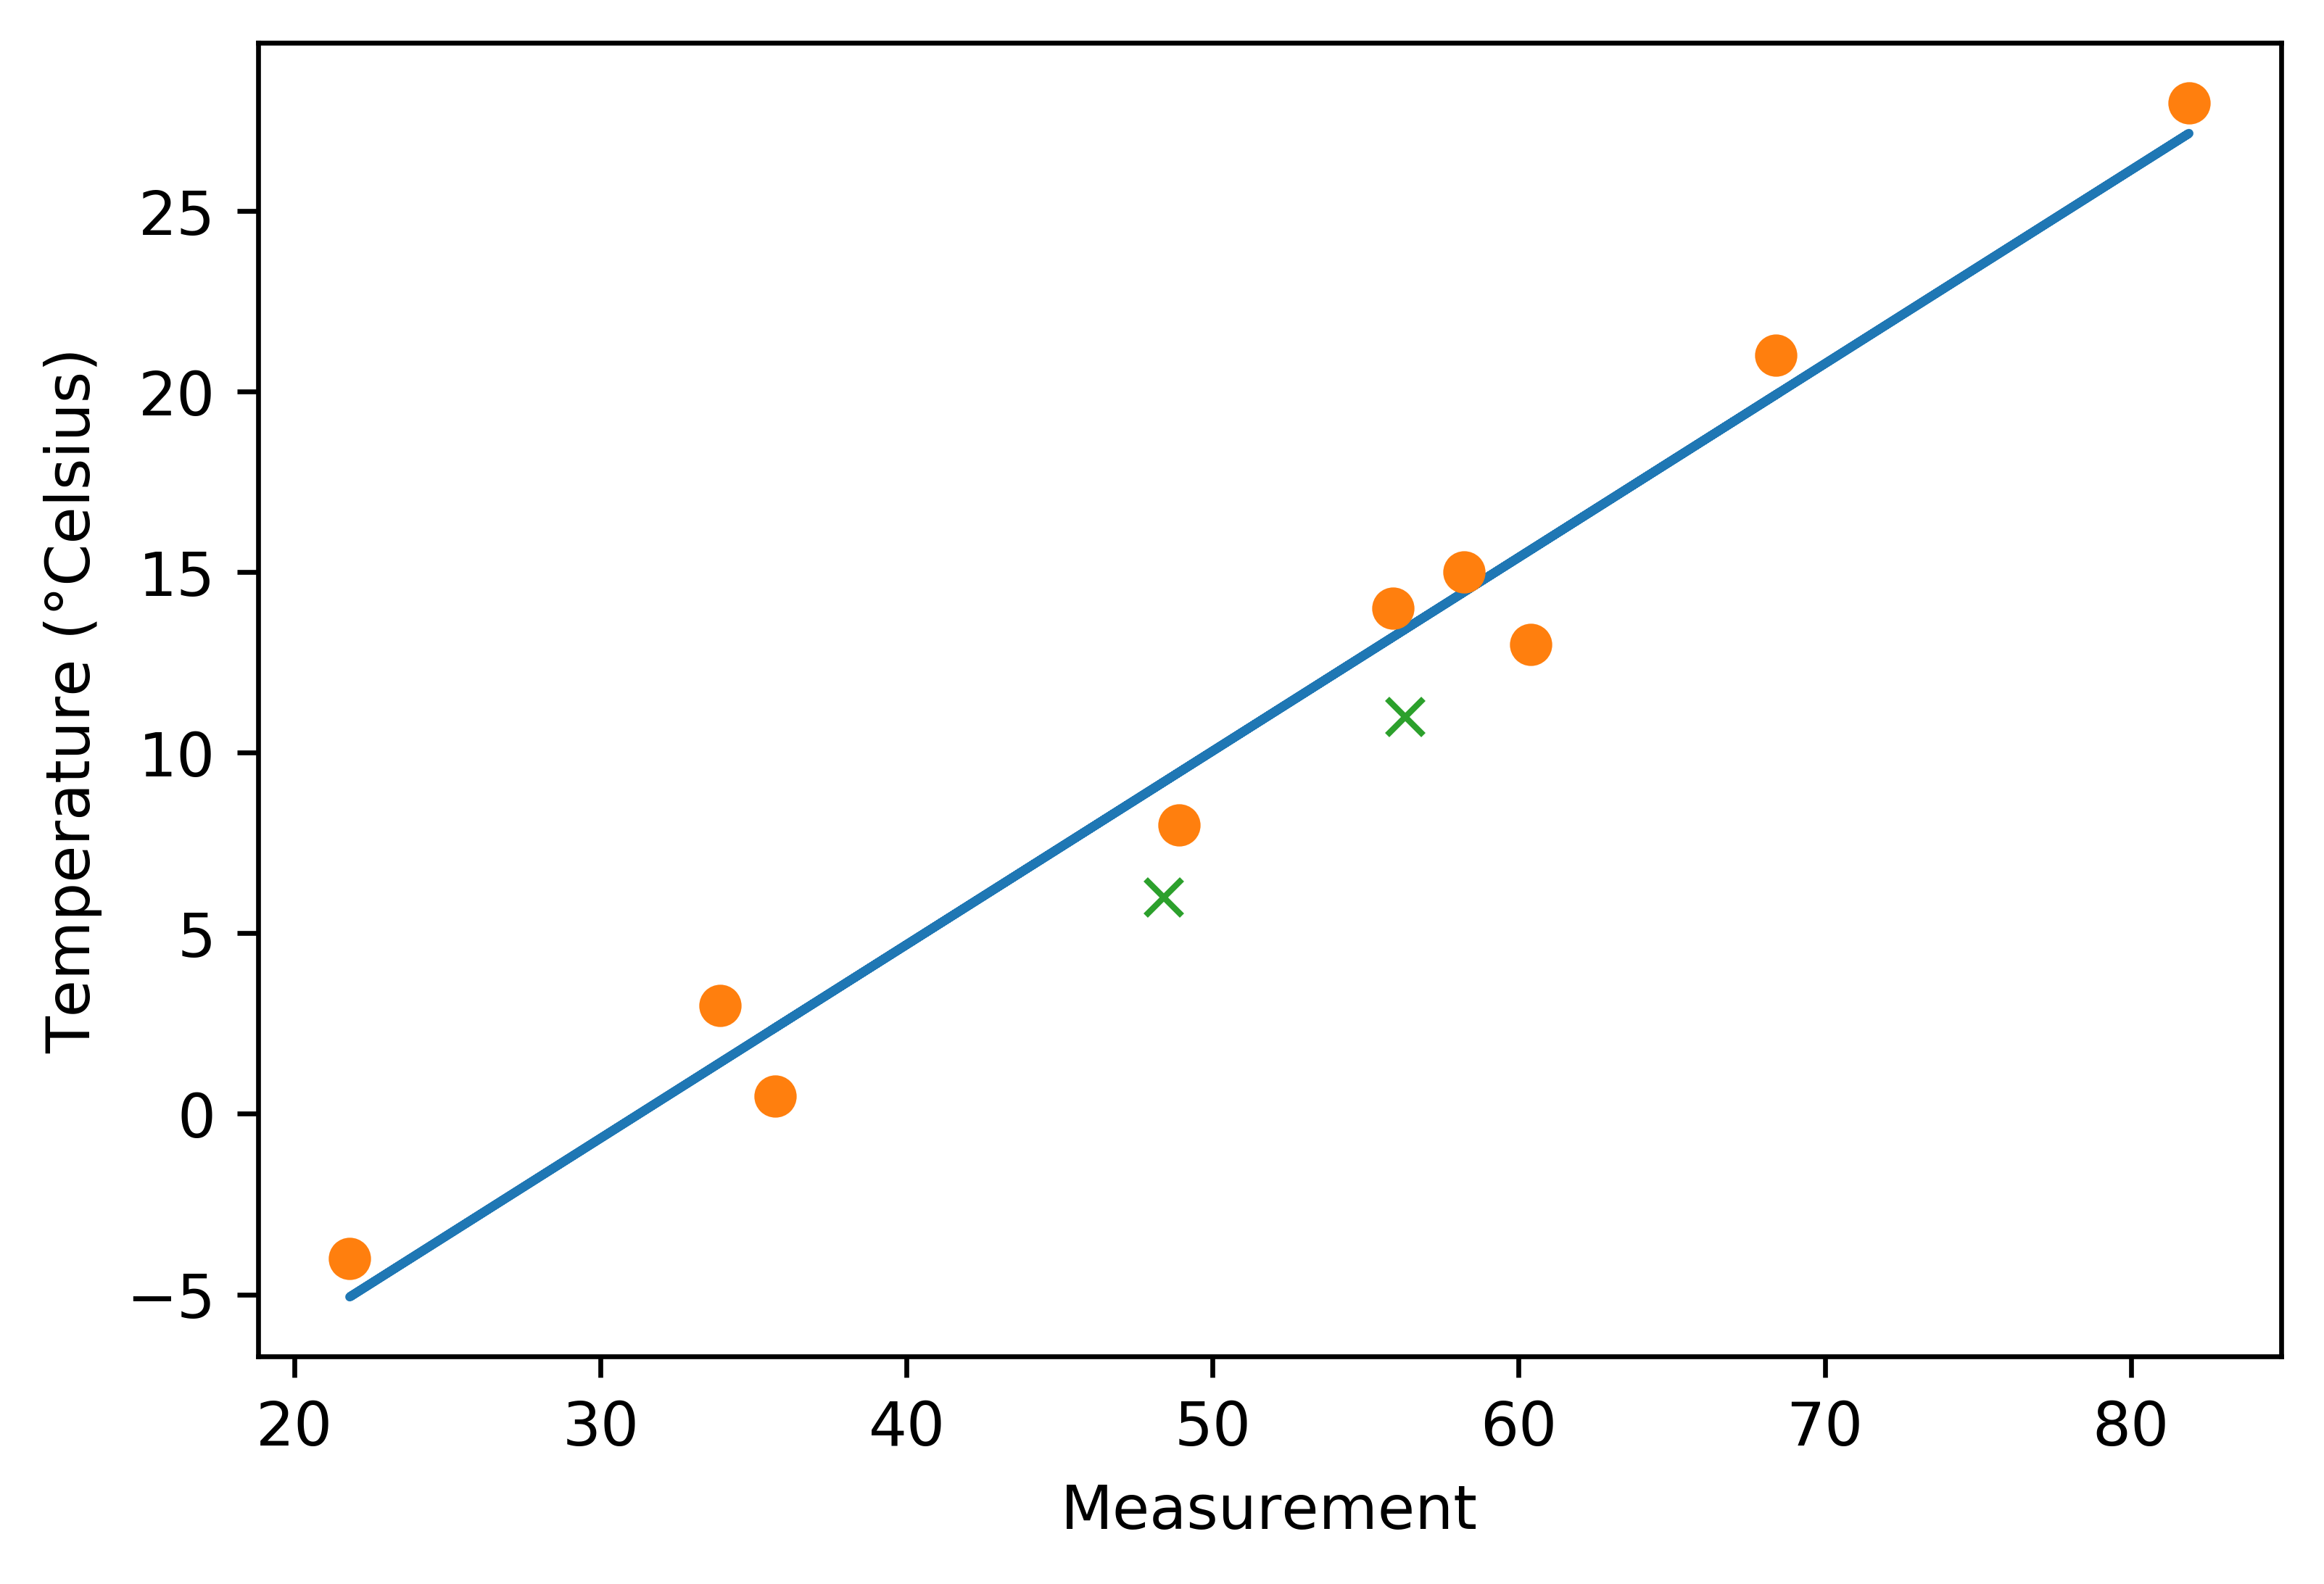

In [48]:
%matplotlib inline
from matplotlib import pyplot as plt

t_p = linear_model(t_u.unsqueeze(1) *0.1 ).squeeze()
print(t_un)
print(t_p)
print(t_u)

fig = plt.figure(dpi=600)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(train_t_u.numpy(), train_t_c.numpy(), 'o')
plt.plot(val_t_u.numpy(), val_t_c.numpy(), 'x')

plt.savefig("separe_training_and_validation_sets.png", format="png")

In [50]:
seq_model = nn.Sequential(
    nn.Linear(1, 13),
    nn.Tanh(),
    nn.Linear(13, 1))
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [52]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [54]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [65]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 13)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(13, 1))
]))
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=13, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=13, out_features=1, bias=True)
)

In [66]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([13, 1])
hidden_linear.bias torch.Size([13])
output_linear.weight torch.Size([1, 13])
output_linear.bias torch.Size([1])


In [67]:
seq_model.output_linear.weight

Parameter containing:
tensor([[-0.2083, -0.1413, -0.0640,  0.2753,  0.0630,  0.0491, -0.0029,
         -0.0218,  0.2578,  0.2737, -0.1258,  0.0500, -0.1922]],
       requires_grad=True)

In [68]:
train_t_u.unsqueeze(1).shape

torch.Size([9, 1])

In [69]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-2)
training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = train_t_u.unsqueeze(1) * 0.1,
    t_u_val = val_t_u.unsqueeze(1) * 0.1,
    t_c_train = train_t_c.unsqueeze(1),
    t_c_val = val_t_c.unsqueeze(1))

Epoch 1, Train loss 214.7968, Validation loss 81.1889
Epoch 1000, Train loss 6.8217, Validation loss 24.8214
Epoch 2000, Train loss 1.9310, Validation loss 9.2567
Epoch 3000, Train loss 1.6851, Validation loss 7.7259
Epoch 4000, Train loss 1.2731, Validation loss 5.7337
Epoch 5000, Train loss 1.1534, Validation loss 5.1494


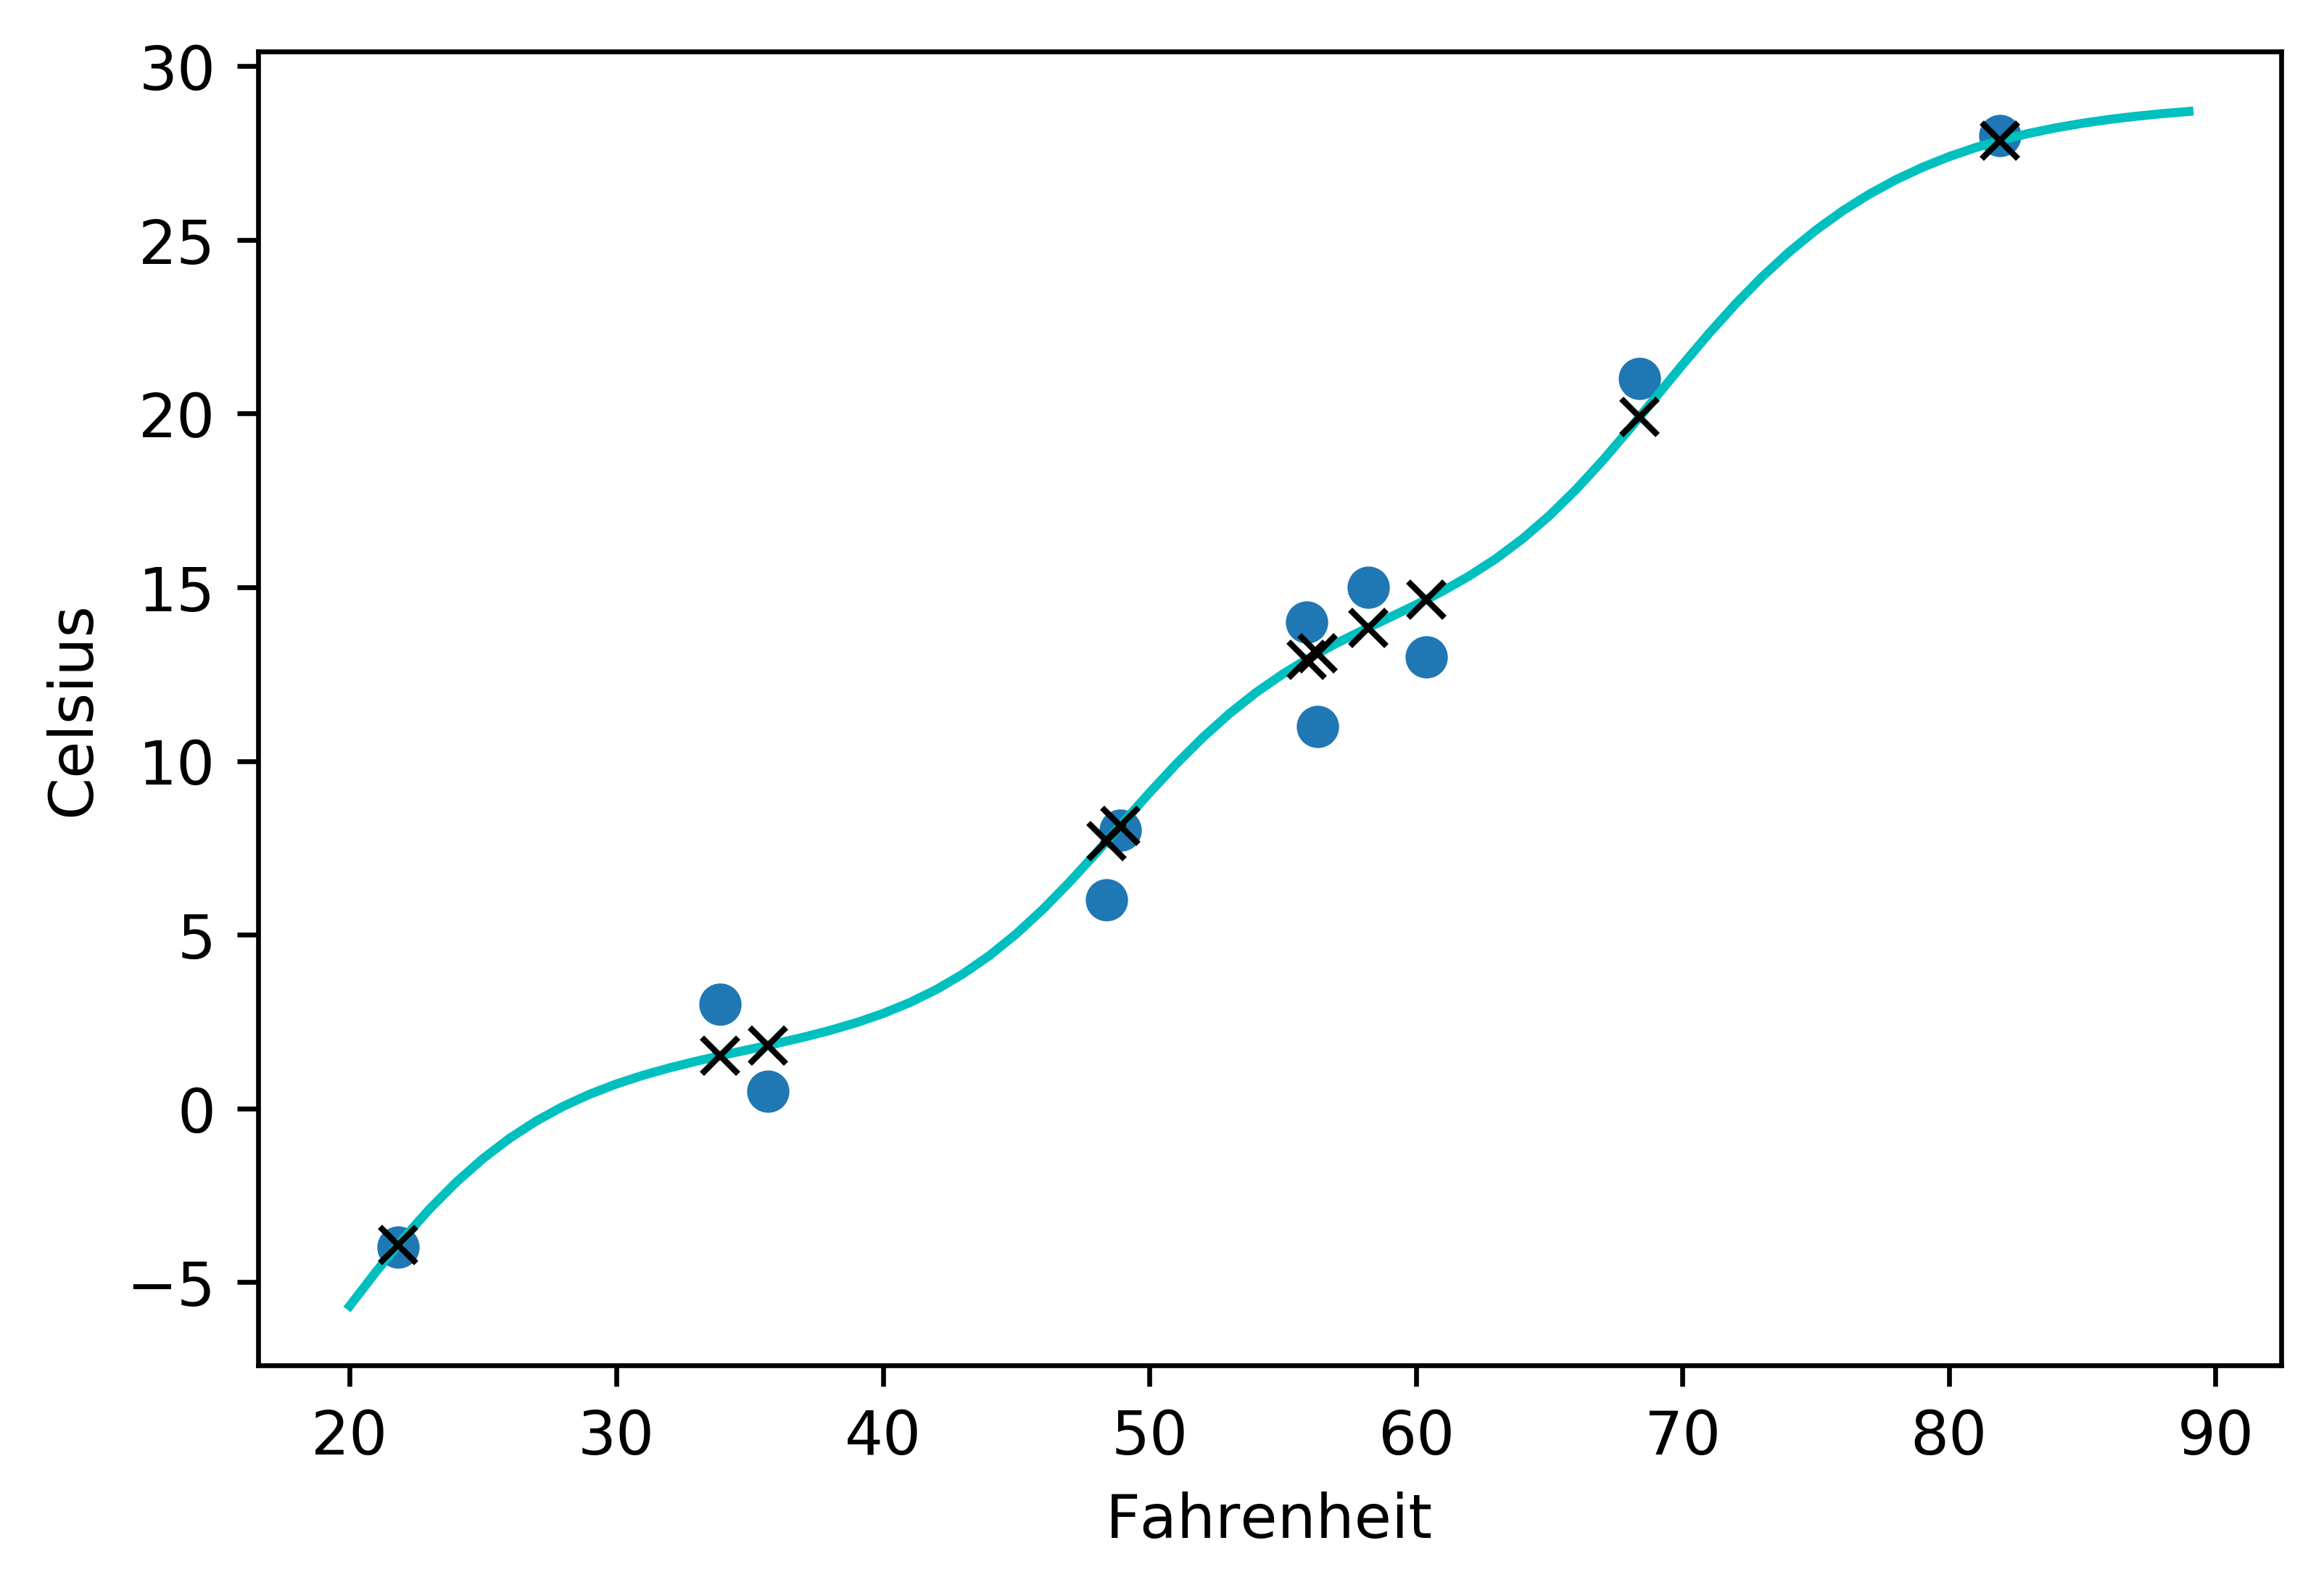

In [73]:
from matplotlib import pyplot as plt
t_range = torch.arange(20., 90.).unsqueeze(1)
fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u.unsqueeze(1)).detach().numpy(), 'kx')

plt.savefig("nn_separe_training_and_validation_sets.png", format="png")